## Competitiveness 
The competitiveness of a recommendation set (or session) is a measure that represent how similar the items in a recommendation session are. 

Ideally, a decent recommender system should return recommendation sets that are competitive. 

In the case of recommender systems that incorporate diversity, it’s also expected that the recommendation set will

- return a recommendation set that is revenant to the user (i.e. satisfies the user query and profile).
* *question:* should diverse recommendations have different qualities?


Tags: #phd

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

# IMPORTANT: change this to point to directory of the project.
PROJECT_DIR = '/Users/khalil/projects/explanations'
os.chdir(PROJECT_DIR)

# import project-specific modules
from preambles import *
from config import Config
from elastic import load_explanations

logging.getLogger().setLevel(logging.WARNING)

In [7]:
config_paths = get_config_paths('./etc/')

In [8]:
%%time

def load_all_datasets():
    """Load seed rankings for all datasets."""
    for idx, path in enumerate(config_paths):
        config = Config.from_file(path).__dict__
        df_explanations = load_explanations(config['es_host'], config['session_index'])
        dataset, strength_fn, weigths = config['short_name'].split('-')
        df_explanations['dataset'] = dataset
        df_explanations['strength_fn'] = strength_fn
        df_explanations['weigths'] = weigths
        df_explanations['short_name'] = config['short_name']

        yield df_explanations
    
df_explanations_all = pd.concat(load_all_datasets())

CPU times: user 6min 15s, sys: 3min 11s, total: 9min 27s
Wall time: 10min 48s


### How competitive are the sessions?

In [9]:
columns = ['session_id', 'target_item_id', 'dataset', 'target_item_average_rating']
fns =[np.mean, np.std, np.var, stats.iqr, np.ptp]

df_summary = (df_explanations_all[columns].drop_duplicates()
              .groupby(['dataset', 'session_id'])
              .agg({'target_item_average_rating': fns}))

datasets = frozenset(df_summary.reset_index('session_id').index.unique())
dataset_lookup = {
    'ba': 'BeerAdvocate',
    'ta': 'TripAdvisor',
    'yp': 'Yelp'
}

In [27]:
def plot_hist(col_to_plot, xlabel, figsize=(12,5)):
    title = '{} of the average rating per session. (note: x-axes and y-axes have different scales)'
    fig, axes = plt.subplots(ncols=len(datasets), figsize=figsize)
    
    if len(datasets) == 1: axes = [axes]
    
    for dataset, ax in zip(datasets, axes):
        _df = df_summary.ix[dataset].reset_index('session_id')[col_to_plot]
        _df_mean = _df.mean()
        ax = _df.hist(ax=ax)
        ax.axvline(_df_mean, c='r')
        ax.set_title(
            '{} ($\mu$={:.2f} $\pm$ {:.2f})'.format(dataset_lookup[dataset], _df_mean, _df.std()), 
            fontsize='small'
        )
        ax.set_xlabel(xlabel, fontsize='small')
        plt.suptitle(title.format(xlabel))
        

def plot_box(col_to_plot, xlabel, figsize=(12,5)):
    title = '{} of the average rating per session. (note: y-axes have different scales)'
    fig, axes = plt.subplots(ncols=len(datasets), figsize=figsize)
    
    if len(datasets) == 1: axes = [axes]
    
    for dataset, ax in zip(datasets, axes):
        _df = df_summary.ix[dataset].reset_index('session_id')[col_to_plot]
        _df_mean = _df.mean()
        ax = _df.plot(kind='box', ax=ax, showmeans=True)
        ax.set_title(
            '{} ($\mu$={:.2f} $\pm$ {:.2f})'.format(dataset_lookup[dataset], _df_mean, _df.std()), 
            fontsize='small'
        )
        ax.set_xlabel(xlabel, fontsize='small')
        plt.suptitle(title.format(xlabel))

### Average rating per session

The average rating of a session can give us a sense of its competitiveness. This will be apparent when we observe the distribution of the average ratings of sessions across each dataset.

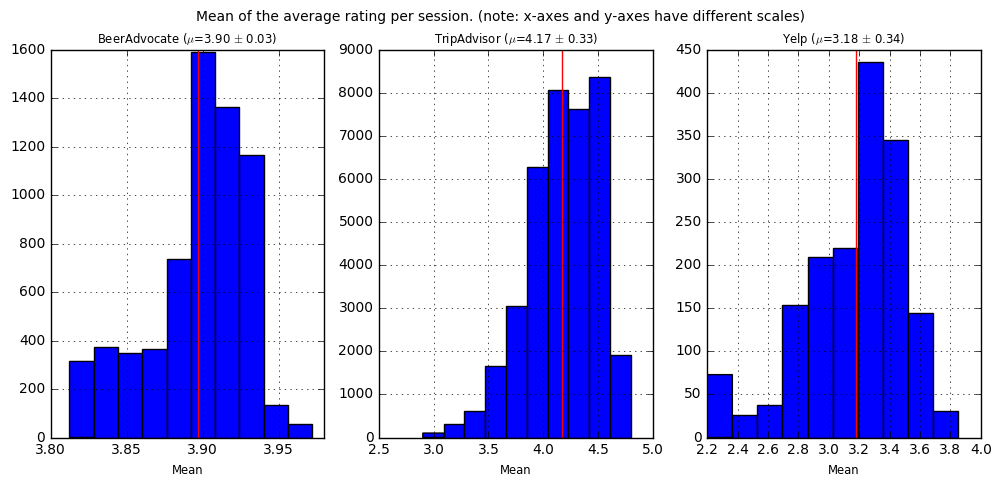

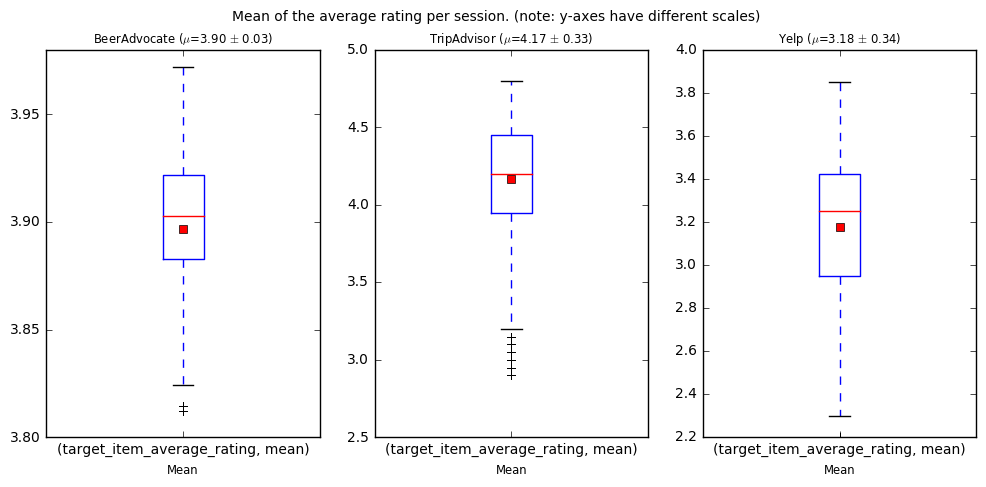

In [28]:
plot_hist(
    col_to_plot=('target_item_average_rating', 'mean'),
    xlabel='Mean'
)
plot_box(
    col_to_plot=('target_item_average_rating', 'mean'),
    xlabel='Mean'
)

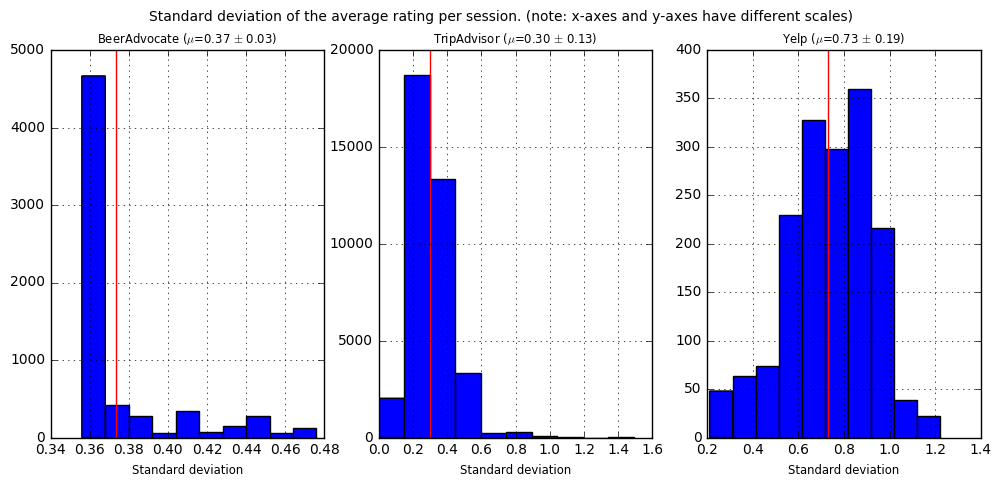

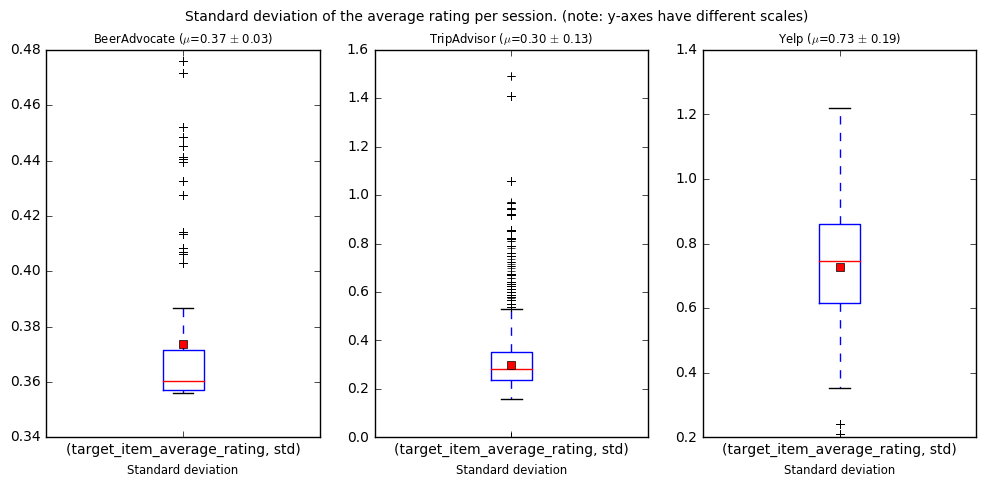

In [29]:
plot_hist(
    col_to_plot=('target_item_average_rating', 'std'),
    xlabel='Standard deviation'
)
plot_box(
    col_to_plot=('target_item_average_rating', 'std'),
    xlabel='Standard deviation'
)

### Range (or Point-to-Point)

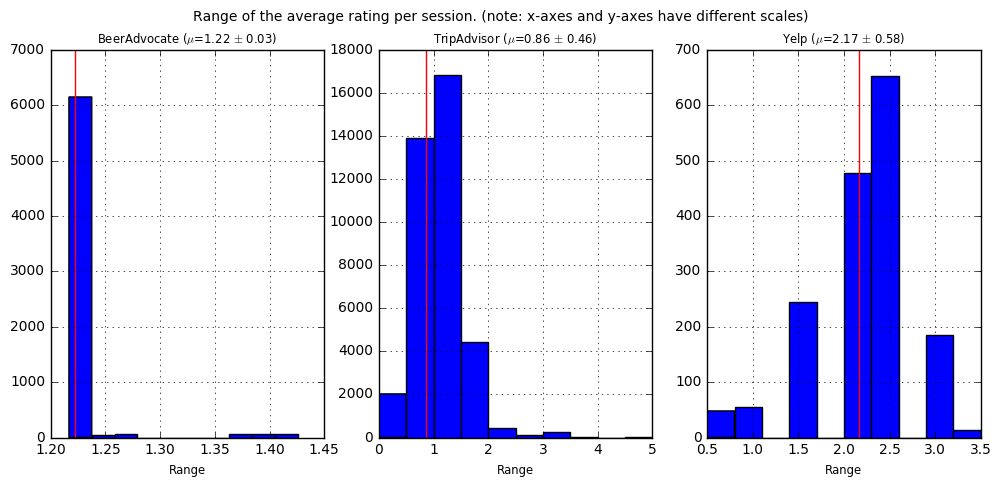

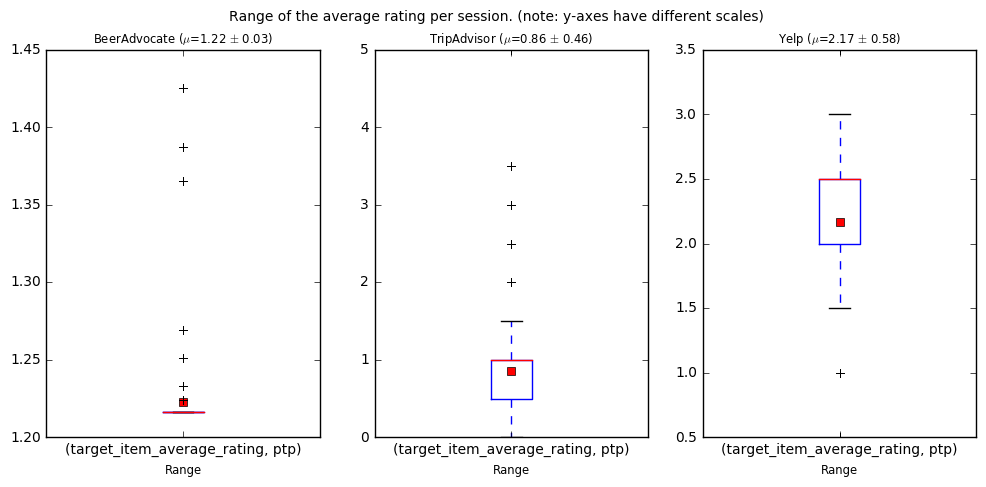

In [30]:
plot_hist(
    col_to_plot=('target_item_average_rating', 'ptp'),
    xlabel='Range'
)
plot_box(
    col_to_plot=('target_item_average_rating', 'ptp'),
    xlabel='Range'
)

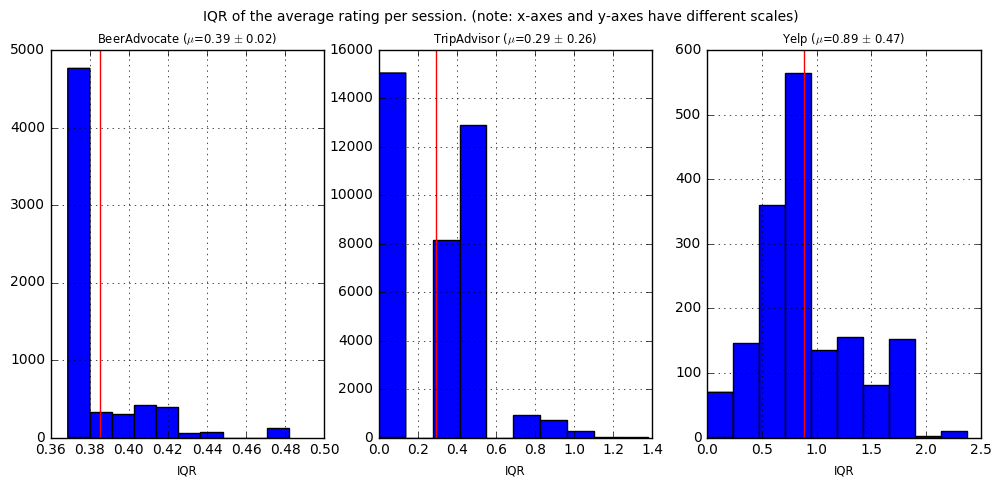

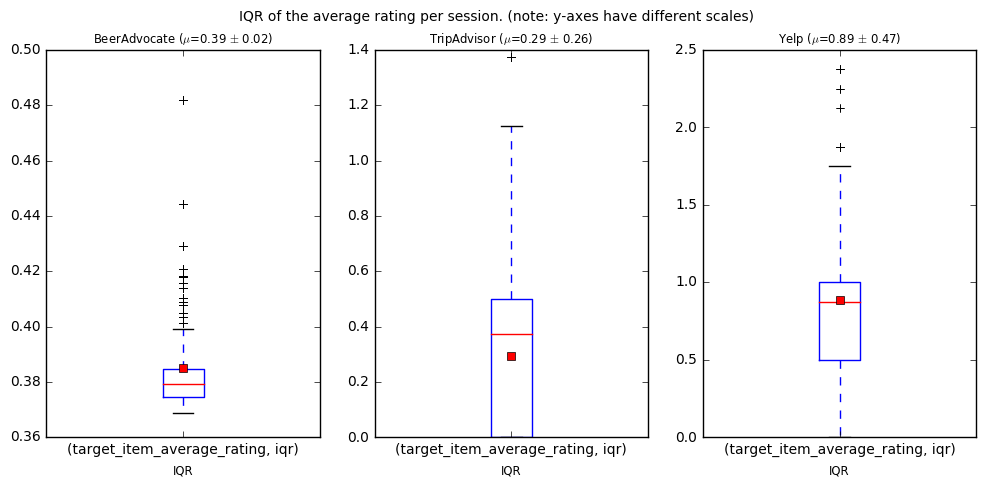

In [31]:
plot_hist(
    col_to_plot=('target_item_average_rating', 'iqr'),
    xlabel='IQR'
)
plot_box(
    col_to_plot=('target_item_average_rating', 'iqr'),
    xlabel='IQR'
)

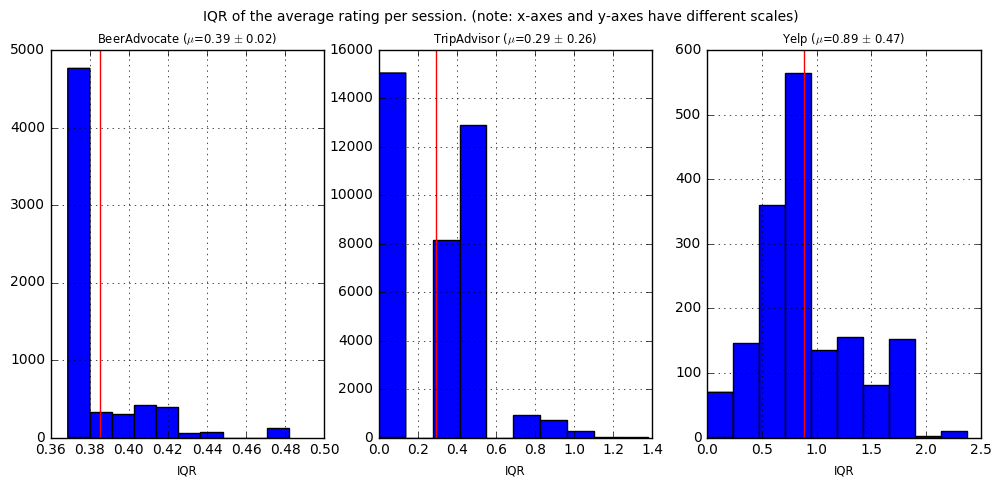

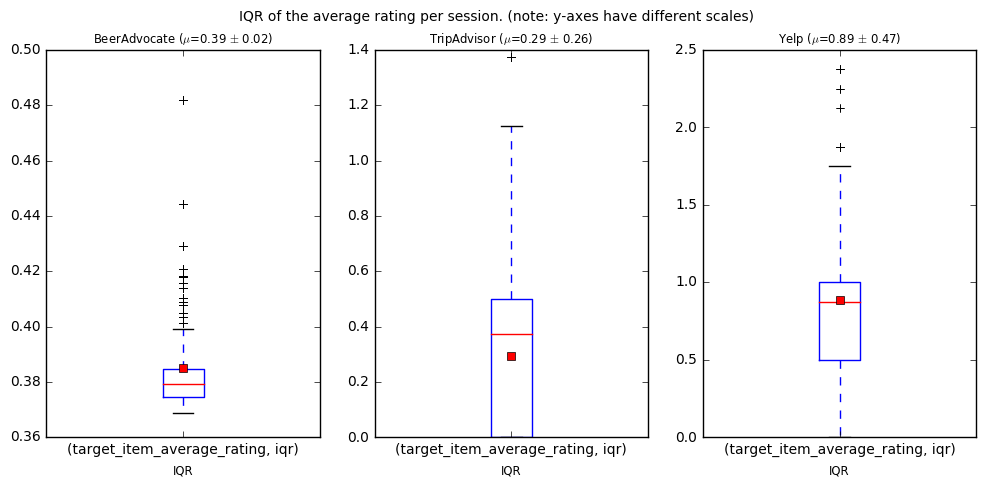

In [32]:
plot_hist(
    col_to_plot=('target_item_average_rating', 'iqr'),
    xlabel='IQR'
)
plot_box(
    col_to_plot=('target_item_average_rating', 'iqr'),
    xlabel='IQR'
)